In [1]:
# tiff > portable movie viewer 

# Cyna Shirazinejad
# 6/19/20

# capabilities needed:
# - auto-segmentation (once we establish: organelles we'll be working with, expression levels, cell types, etc.)
# - auto-tracking of puncta (CME), blobs (organelles) that is then overlaid on images
# - text annotation: scale bar, channel names (auto-extracted from image title), markers, imaging settings (exposure, frame rate, intensity), conditions, timestamp (minute and seconds)


# pulse chase/stimulation: digital toggle indicating where 
# - photobleaching correction (probably exponential fit to start with)
# - extension/generalization to other data formats (TIFFS), Hd5



In [2]:
# not necessary unless running vm
# !source ~/.bash_profile


In [88]:

# import all necessary Python libraries

# configure the Jupyter Notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
%gui qt

import pickle
import napari 
import imageio
import os
import sys
# import z5py

import numpy as np
from os import listdir
from os.path import isfile, join
from ipywidgets import interact, interactive, fixed, interact_manual # for interactive widgets
import dask.array as da
import dask
import tifffile
import subprocess
import scipy as sp
import scipy.optimize
sys.path.append(os.path.abspath(os.getcwd() + '/visualization_python_scripts_cyna'))
from visualization_nd2 import return_widgets_for_display, make_movie
from dask_to_napari import (convert_tiffs_to_dask_arrays, 
                            view_one_channel, 
                            view_one_time_one_channel,
                            view_specified_channels_one_time,
                            populate_grid)
from visualization_utilities import add_3d_axes
from skimage.io import imread
from dask import delayed
import tifffile
import dask.array as da
from glob import glob
from PIL import Image
from pims import ImageSequence
# import dask_image
import imageio
from naparimovie_wrappers import MovieBuilder

import math
from naparimovie import Movie

!jupyter nbextension enable --py widgetsnbextension


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [ ]:
# list the XY and Z spacing 

# we will need to import the
# z spacing
dz = 0.5;

skew_angle = math.radians(31.5) 
# frame rate

# x y pixel size
xyPixelSize = 0.108;

# z spacing after deskew
z_spacing = dz*math.sin(skew_angle)

In [2]:
# the path you are in 
!pwd

/y/pyLattice/src/visualization


# Here put the name of the folder of experiments
## e.g. the parent folder, where the daughter folders are 'exp01' 'exp02' etc

In [80]:
# name of the folder where you might have several experiments
imaging_overall_folder = '../../../ABCData/'

current_folder = '20200716_p35p4_WTCiPS_Ap2_tRFPt_ER_ERtracker_ArpC3_tGFP_nsp3nsp4_halo635/'

expts_folder = os.path.join(imaging_overall_folder, current_folder)
expts_folder

'../../../ABCData/20200716_p35p4_WTCiPS_Ap2_tRFPt_ER_ERtracker_ArpC3_tGFP_nsp3nsp4_halo635/'

In [78]:
# figure out which subfolders contain deskew and decon data
ds_dirs = []
decon_dirs = []
for folder in next(os.walk(expts_folder))[1]:
    for subfolder in next(os.walk(expts_folder+folder))[1]:
            if subfolder.startswith('DS'):
                ds_dirs.append(folder)
                for subsubfolder in next(os.walk(os.path.join(expts_folder,folder,subfolder)))[1]:
                    if 'decon' in subsubfolder:
                        decon_dirs.append(folder)
                
print('folders with deskew data: ')
print(ds_dirs)
print('folders with decon data: ')
print(decon_dirs)

folders with deskew data: 
['exp02_3color_200mW_xstage_z0p5', 'exp03_3color_200mW_xstage_z0p5', 'exp04_3color_200mW_xstage_z0p5', 'xp01_3color_200mW_xstage_z0p5']
folders with decon data: 
['exp02_3color_200mW_xstage_z0p5', 'exp03_3color_200mW_xstage_z0p5', 'exp04_3color_200mW_xstage_z0p5', 'xp01_3color_200mW_xstage_z0p5']


# choose one folder
## decon_dirs[0] or decon_dirs[1] etc

In [103]:
expt_to_visualize = decon_dirs[0]
path_to_decon = os.path.join(imaging_overall_folder, current_folder, expt_to_visualize)

In [ ]:
# # to format the list of folders more nicely into a pandas dataframe                
# indecies = range(len(output_dirs))

# output_dirs.sort()
# config_dirs.sort()

# all_dirs={}

# all_dirs['output'] = output_dirs
# all_dirs['config'] = config_dirs

# all_dirs_df = pd.DataFrame(data = all_dirs)

In [57]:
# figure out time interval

# use the time interval between the first two files 

# list all the file names
channel_file_names = os.listdir(path_to_decon)

# pick just the tif files
tif_file_names=[]
for file in channel_file_names:
    if file.endswith('.tif'):
        tif_file_names.append(file
                             )
# sort tif files alphabetically
tif_file_names.sort()

# figure out which _delimiter_ ends with 'msec'
# note theres suaully an absolute time too
for index, delimiter in enumerate(os.listdir(path_to_decon)[0].split('_')):
    if delimiter.endswith('msec'):
#         print(str(index))
        time_delimiter_index = index
    
file_name_0 = tif_file_names[0].split('_')[time_delimiter_index][:-4]
file_name_1 = tif_file_names[1].split('_')[time_delimiter_index][:-4]
interval = np.abs(np.float(file_name_1)-np.float(file_name_0))

interval_seconds = interval/1000
print('Time interval: ' + str(interval_seconds) + ' seconds')

Time interval: 9.606 seconds


In [8]:
# convert tiffs to a dask array
# a list of lists. each internal list has filesnames for each channel
channels_dask = convert_tiffs_to_dask_arrays(path_to_decon,
                                             channel_identifiers=None,
                                             is_MIP=False,
                                             verbose=True)

Index of camera designation is 1
Index of channel designation is 2
Index of stack designation is 4
The stacks present in this file are: ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099']
The channels will be returned in the following order linked to 

In [9]:
channels_dask

,Array,Chunk
Bytes,216.31 GB,73.53 MB
Shape,"(3, 100, 131, 1600, 860)","(3, 50, 57, 50, 43)"
Count,3841 Tasks,3840 Chunks
Type,float32,numpy.ndarray


# Optionally convert from dask array to zarr array
## you can skip this step if your data set is not gigantic

In [ ]:
# try to put it in a folder called to_zarr

In [83]:
# channels_dask.to_zarr("zarr_data")

In [6]:
# channels_from_zarr=da.from_zarr("zarr_data")

In [7]:
# channels_from_zarr

dask.array<from-zarr, shape=(1, 1, 151, 1600, 939), dtype=float32, chunksize=(1, 1, 151, 400, 313), chunktype=numpy.ndarray>

# Here is where you use napari.add_viewer to make a viewer window containing the dask_array
## inputting either "dask_array" or "channels_from_zarr"

In [10]:
# initialize the viewer
viewer=napari.Viewer(ndisplay=3)


In [11]:
# add each channel
viewer.add_image(channels_dask[0],colormap='cyan')


<Image layer 'Image' at 0x1d4b0f42ac0>

In [12]:
viewer.add_image(channels_dask[1],colormap='yellow', blending='additive')


<Image layer 'Image [1]' at 0x1d4c6850160>

In [13]:
viewer.add_image(channels_dask[2],colormap='magenta', blending = 'additive')


<Image layer 'Image [2]' at 0x2072652b550>

In [56]:
# This part is to automate the channel visualization thresholds 

In [ ]:
# # build the necessary widgets for the visualization tools

# # use the following entry boxes and sliders to set the percentile of intensities in each available channel 
# # to set the lower and upper cut-offs in percentiles allowed for display
# # these are set to 0 and 100, respectively
# num_channels, channels_to_view, channels_thresholded, percentile_ranges, all_percentiles_entrybox_lower_upper, threshold_options, image_dimensionality_array, axes_available, image_frames, display_widget, make_napari_movie=return_widgets_for_display(channels_dask)

# for i in range(num_channels*2):
#     display(all_percentiles_entrybox_lower_upper[i], percentile_ranges[i])

In [27]:
# make a grid multi or separate channels. this is optional
## # 1,1 is a 1x1 grid
#1x1 grid
# populate_grid(napari.Viewer(ndisplay=3), 1,1, [(channels_dask[0],[(0,0)],'magenta','ch0')])


In [44]:
# to make a 4x4 grid ? each channel and overlay 
# overall there are 4 panels

# populate_grid(napari.Viewer(ndisplay=3), 4 , 4, [(channels_dask[0],[(0,0),(3,3)],'magenta','ch0'),(channels_dask[1],[(1,1),(3,3)],'cyan','ch1'),(channels_dask[2],[(2,2),(3,3)],'yellow','ch2')])



In [ ]:
# create a napari viewer that is linked to a movie "state" output for movie generation
# output = interactive(
#             make_movie,
#             {'manual': True},
#             channels_to_display=channels_to_view,
#             channels_to_threshold=channels_thresholded,
#             threshold_methods=threshold_options,
#             percentile_values=fixed(all_percentiles_entrybox_lower_upper),
#             display_on=display_widget,
#             file_to_process=fixed(file_to_process),
#             image_dimensionality_array=fixed(image_dimensionality_array),
#             axes_available=fixed(axes_available),
#             image_frames=fixed(image_frames),
#             make_naparimovie=make_napari_movie
#            )
# display(output) # display the napari viewer widgets and display tools
# select the channels to view (hold control/command to highlight multiple lines)
# select the channels to threshold; if a channel is selected for thresholding, a threshold method must be specified
# chose between no threshold, single-Otsu, and percentile


# Make a movie_script file
## need a folder called visualization_scripts_new

In [ ]:
# if make naparimovie is checked, check if this global variable is carried over from the scripts
# this "movie" object is what naparimovie will render into a movie
# this cell must be run after every new run of display(output) so the most up-to-date napari viewer is used
# movie = output.result

In [90]:
# i sets a unique string name for the movie script
i=1

In [93]:
# for 1 channels, many time, 1 z stack
# # # %%capture
# number of channels in movie to generate script for
number_of_channels = 1
movie_text_command="visualization_scripts/movie_script"+str(i)+".txt"
# the granularity of angled rotations in function calls
# increase for smoothness (will take longer to render)
# decrease for testing script generations
# number_frames_per_unit_rotation = 5
# unit_rotation_degrees=15



# initialize the first frame in the naparimovie
# can be greater than 0 if you want a pause at the beginning
# the first "camera" frame of the naparimovie will start as the current
# state of the napari window. therefore, all contrast settings and visualization tweaks
# can be made in napari before starting the gif generation follow script generation

frame_start = 0

movie_current = MovieBuilder()

movie_current.shift_time(40,90)

# you can optionally get the frame of the movie for the next state as a return from any operation
# fim=movie_current.make_all_layers_invisible(2)

# you can manually set the frame in the movie for an increased duration
# movie_current._frame_in_movie = 20

# make the movie script
movie_current.build_movie('visualization_scripts/movie_script'+str(i)+'.txt')



In [94]:
# initialize a napariMovie instance
movie = Movie(myviewer=viewer)

ValueError: key combination F already used! specify 'overwrite=True' to bypass this check

In [112]:
# make a subfolder called movies and visit that folder
os.chdir(expts_folder)
if not os.path.exists('movies'):
    os.makedirs('movies/')
    os.chdir('movies')

In [ ]:
# # create a series of naparimovie interpretable commands for generating a movie
movie.create_state_dict_from_script('visualization_scripts/movie_script'+str(i)+'.txt')

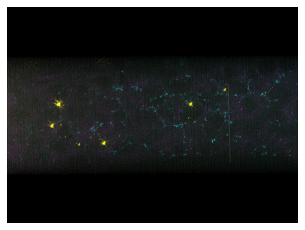

In [113]:
# # generate the mp4 movie with the set fps and resolution
# # movie.make_gif('/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/all_movies_made_by_cyna/20200703_nsp3-4 transfection/Sec61-lamin/Sec61-GFP_laminRFP_noTransfection_002'+'.gif')
movie.make_movie(current_folder[:-2]+'__'+expt_to_visualize+'_movie.mp4',fps=10, resolution = 500)

In [ ]:
# save your movie as a gif

In [ ]:
# make shapes. we're not using this yet

In [ ]:
# with napari.gui_qt():
#     # add the image
#     viewer=napari.Viewer(ndisplay=3)
#     viewer.add_image(channels_from_zarr[0],colormap='viridis')
#     shape_of_file = channels_from_zarr[0].shape
#     text_properties = {
#     'text': '{class}: {likelihood:0.1f}%',
#     'anchor': 'upper_left',
#     'translation': [-5, 0],
#     'size': 8,
#     'color': 'green',
#     }

#     # add polygons
#     shapes_layer = viewer.add_shapes(
#         polygons,
#         properties=properties,
#         shape_type='polygon',
#         edge_width=3,
#         edge_color='class',
#         edge_color_cycle=edge_color_cycle,
#         face_color='transparent',
#         text=text_properties,
#         name='shapes',
#     )
#     add_3d_axes(viewer, 
#                 shape_of_file,
#                 extension=[0,0,-600], 
#                 marker_width=3,
#                 offset=[0, 0, 0], 
#                 points_on_axes=(3,10,10))